### Import libraries

In [122]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load fashion_mnist data

Load dataset and info using tensorflow datasets. <br>
Even though fashion mnist is stored in a single file, let's shuffle it because it is a good practice. <br>
Since we are going to train ResNet in supervised way, we need labels. Let's set as_supervised as True.

In [111]:
(ds_train, ds_valid, ds_test), info = tfds.load(
    "fashion_mnist",
    split=['train[:90%]', 'train[90%:100%]', 'test'],
    shuffle_files=True,
    as_supervised=True, 
    with_info=True
)

Tensorflow datasets info contains metatdata on dataset. Let's see information on dataset.

In [112]:
print(f'Number of classes: {info.features["label"].num_classes}')
print(f'Labels: {info.features["label"].names}')
print(f'Number of trainig set instances: {len(ds_train)}')
print(f'Number of validation set instances: {len(ds_valid)}')
print(f'Number of test set instances: {len(ds_test)}')
print(f'Shape of image: {info.features["image"].shape}')
print(f'Shape of label: {info.features["label"].shape}')

Number of classes: 10
Labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of trainig set instances: 54000
Number of validation set instances: 6000
Number of test set instances: 10000
Shape of image: (28, 28, 1)
Shape of label: ()


### Build a training pipeline

Normalize data so that each value ranges from 0 to 1. <br>
Cache the dataset to memory for better performance. <br>
Shuffle for the randomness. <br>
Set number of batches to 256. Batching should be done after shuffling. <br>
Set prefetch so that input pipeline can get ready for next step. tf.data.AUTOTUNE will tune the value at runtime.

In [113]:
def preprocess(image, label):
    """Normalizes images and converts label to categorical"""
    image = tf.cast(image, tf.float32) / 255
    label = tf.one_hot(label, 10)
    return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(256)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_valid = ds_valid.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.batch(128)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

Shuffling is not required.

In [114]:
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

### Create a ResNet-34 model

Let's implement a ResNet-34 model from scratch.<br>
ResNet-34 is a variant of ResNet which is a deep CNN composed of 34 layers.<br>
ResNet is characterized by its <i>residual units</i> (RUs) with skip connection.<br>
Since its unique form, we need to implement residual unit layer first when we create a ResNet model.

In [115]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
          keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
          keras.layers.BatchNormalization(),
          self.activation,
          keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
          keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
                ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Now that we've got Residual Unit Layer class, let's implement ResNet-34 from scratch

In [116]:
resNet34 = keras.models.Sequential()
resNet34.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[28, 28, 1], padding="same", use_bias=False))
resNet34.add(keras.layers.BatchNormalization())
resNet34.add(keras.layers.Activation("relu"))
resNet34.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    resNet34.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
resNet34.add(keras.layers.GlobalAvgPool2D())
resNet34.add(keras.layers.Flatten())
resNet34.add(keras.layers.Dense(10, activation="softmax"))

Summary shows the models 34 layered architecture.

In [117]:
resNet34.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization_72 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit_32 (ResidualUn (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_33 (ResidualUn (None, 7, 7, 64)          74240     
_________________________________________________________________
residual_unit_34 (ResidualUn (None, 7, 7, 64)         

### Train the ResNet-34

In [119]:
resNet34.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])
history = resNet34.fit(
    ds_train, 
    epochs=10,
    validation_data=ds_valid
)

Epoch 1/10


2022-02-26 20:32:46.288473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.8388

2022-02-26 20:33:40.237250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - 56s 260ms/step - loss: 0.4543 - accuracy: 0.8388 - val_loss: 2.5936 - val_accuracy: 0.3352
Epoch 2/10
211/211 [==============================] - 52s 246ms/step - loss: 0.3028 - accuracy: 0.8876 - val_loss: 0.4940 - val_accuracy: 0.8160
Epoch 3/10
211/211 [==============================] - 52s 249ms/step - loss: 0.2633 - accuracy: 0.9018 - val_loss: 0.3499 - val_accuracy: 0.8752
Epoch 4/10
211/211 [==============================] - 53s 250ms/step - loss: 0.2335 - accuracy: 0.9145 - val_loss: 0.3932 - val_accuracy: 0.8698
Epoch 5/10
211/211 [==============================] - 52s 246ms/step - loss: 0.2133 - accuracy: 0.9194 - val_loss: 0.3326 - val_accuracy: 0.8878
Epoch 6/10
211/211 [==============================] - 52s 248ms/step - loss: 0.1977 - accuracy: 0.9256 - val_loss: 0.3893 - val_accuracy: 0.8663
Epoch 7/10
211/211 [==============================] - 52s 246ms/step - loss: 0.1801 - accuracy: 0.9320 - val_loss: 0.4010 - val_accuracy: 0.8

### Visualize training results

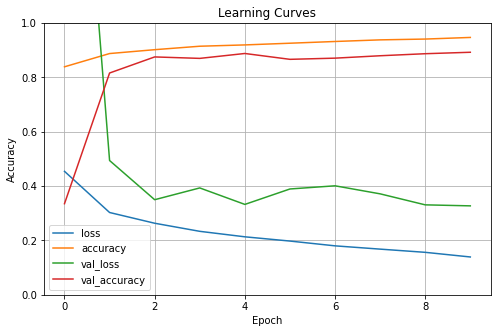

In [125]:
df_history = pd.DataFrame(history.history)
df_history.plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.show()

Validation accuracy is lower than accuracy in every epoch. We can see the model is slightly overfitted to training set.

### Evaluate with test set

In [127]:
loss, accuracy = resNet34.evaluate(ds_test)
print(f'Accuracy on test set: {accuracy}')

79/79 [==============================] - 2s 24ms/step - loss: 0.3656 - accuracy: 0.8823
Accuracy on test set: 0.8823000192642212


Final accuracy of ResNet-34 on Fashion MNIST dataset turns out to be about 88%.

### References

1. Tensorflow Datasets: https://www.tensorflow.org/datasets/keras_example
2. ResNet-34 Implementation: Aurelien Geron. (2019). Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow. O'REILLY.